We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, recall_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Stroke EDA.

In [2]:
### DATA PREPARATION
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv', na_values = [np.NaN, ' '])

df = pd.DataFrame(stroke)
df = df.drop(['id'], axis = 1)

num_vars = df.select_dtypes(include = ['int64', 'float64'])
cat_vars = df.select_dtypes(include = 'object')
feature_names = collections.defaultdict(str)
for name in num_vars.columns:
    feature_names[name]
for name in cat_vars.columns:
    feature_names[name]

mean_imputer = SimpleImputer(strategy = 'mean')
imputed_vars = mean_imputer.fit_transform(num_vars)
df_imputed = pd.DataFrame(np.hstack([imputed_vars, cat_vars]), columns = feature_names)

df_imputed['age'] = df_imputed['age'].astype('float64')
df_imputed['hypertension'] = df_imputed['hypertension'].astype('int64')
df_imputed['heart_disease'] = df_imputed['heart_disease'].astype('int64')
df_imputed['avg_glucose_level'] = df_imputed['avg_glucose_level'].astype('float64')
df_imputed['bmi'] = df_imputed['bmi'].astype('float64')
df_imputed['stroke'] = df_imputed['stroke'].astype('int64')

capping = num_vars.select_dtypes(include = 'float64')
for col in df_imputed.columns:
    if col in capping.columns:
        percentile = df_imputed[col].quantile([0.05, 0.95]).values
        df_imputed[col] = df_imputed[col].clip(lower = percentile[0], upper = percentile[1])
        
df_final = pd.get_dummies(df_imputed, columns = ['gender', 'ever_married', 'work_type', 'Residence_type',
                                              'smoking_status'], drop_first = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2, making sure that the imbalance in the levels of the target variable, y, is maintained in both the sets. In other words, both the training and testing sets have the same proportion of people who did not suffer from stroke and those who did.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df_final.drop(['stroke'], axis = 1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 99)

We now go on to make a simple Decision Tree model, which will serve as our baseline. Remember that the data was highly unbalanced in that the number of people who did not suffer from stroke was far more than those who did. To overcome this problem, we simply set the weights of the levels of y as balanced. What this does is that it assigns weights to the two levels of y, the weight of each level being inversely proportional to its frequency.


So, we build the model with class weights as balanced, fit it to the training data and plot the confusion matrix.

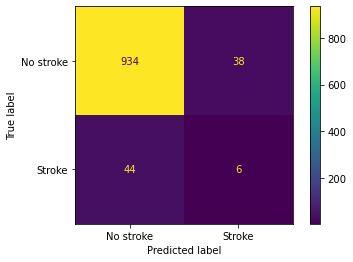

In [4]:
### CREATING A BASELINE MODEL
clf_dt = DecisionTreeClassifier(random_state = 99, class_weight = 'balanced')
clf_dt.fit(X_train, y_train)
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Before we proceed, let's take a look at the distribution of the levels of y in our dataset.

In [5]:
df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Here, we see that around 95% of the people in our dataset have not suffered from stroke as opposed to just about 5% who actually have. This means that even if our model predicts every person as not having a stroke, the model will still be 95% accurate at the very least. So, in this case, accuracy is a deceptive metric. 


What we should rather be concerned with is the number of people who actually had stroke but were not identified by the model as having stroke i.e. the False Negatives. Lower the FN value, lower is the risk of overlooking a possible case of stroke and thus better is the model because the main objective of the model here should be to possibly save lives by correctly identifying a stroke case as early as possible. To reduce the FN value, we need to ensure that the recall of stroke cases is high since recall and FN are inversely proportional.


So, we shall calculate the accuracy and recall values for the predictions made by the model.

In [6]:
### CALCULATING ESSENTIAL METRICS
y_pred_dt = clf_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_dt))
print('Recall score: %f' % recall_score(y_test, y_pred_dt))

              precision    recall  f1-score   support

   No stroke       0.96      0.96      0.96       972
      Stroke       0.14      0.12      0.13        50

    accuracy                           0.92      1022
   macro avg       0.55      0.54      0.54      1022
weighted avg       0.91      0.92      0.92      1022

Accuracy: 0.919765
Recall score: 0.120000


If we look at the confusion matrix, we see that out of the 50 cases that had actually suffered from stroke, only 6 were correctly predicted as having a stroke by our model while the remaining 44 were overlooked. This gives us a recall score of just 12% while the accuracy is about 92%.

Next, we plot the ROC curve and calculate the AUC score.

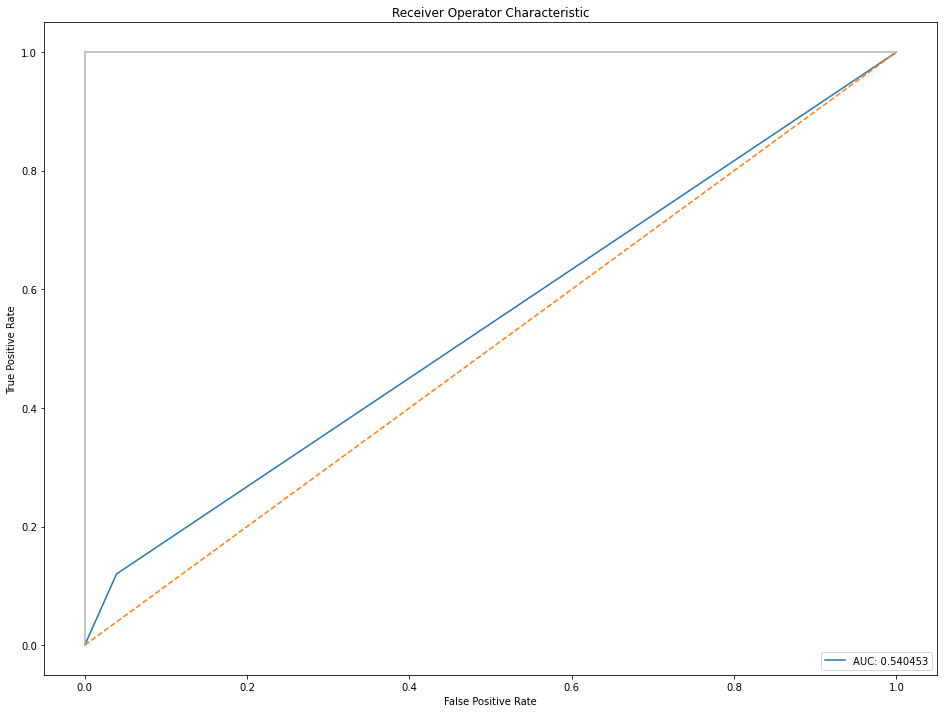

In [7]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_dt = clf_dt.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_dt)
roc_auc = roc_auc_score(y_test, y_prob_dt)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.5404. Thus, we see that our baseline model is a poor one.


We can also plot the tree model that we just made.

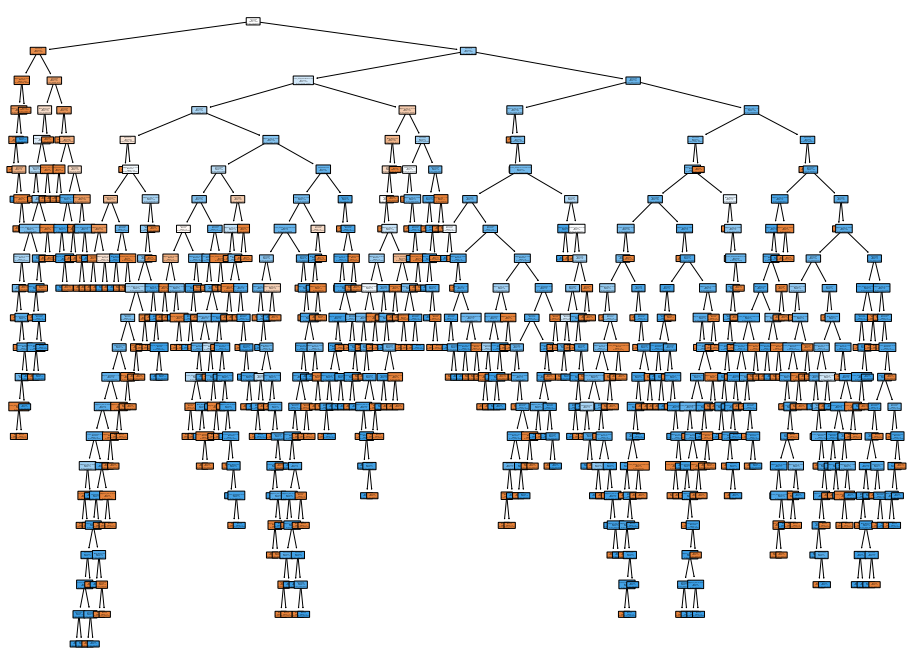

In [8]:
### PLOTTING THE TREE MODEL
plt.figure(figsize = (16, 12))
plot_tree(clf_dt, rounded = True, filled = True, class_names = ['No stroke', 'Stroke'], feature_names = X.columns);

We see that our baseline model is a huge tree which might have been overfit to the training data and thus led to poor performance on the testing data. To improve this, we can try to prune the tree to make it small so that it will fit well with new data. For this, we can make use of Cost Complexity Pruning. 


Suppose we have numerous trees of varying sizes- from a single leaf to the tree in the baseline model, then Cost Complexity Pruning assigns a Tree Score to each tree, where the score of a tree is calculated as the sum of it's SSRs and ccp_alpha times the total number of it's terminal nodes. The tree with the lowest Tree Score is considered to be the pruned tree. 


So, in order to prune the baseline tree model, we shall first need an ideal ccp_alpha value. For this, let us extract a range of possible values for ccp_alpha and then use them to create numerous models with which we can calculate the recall score for both the training and testing sets. We can plot these recall scores on a graph against the ccp_alpha values.

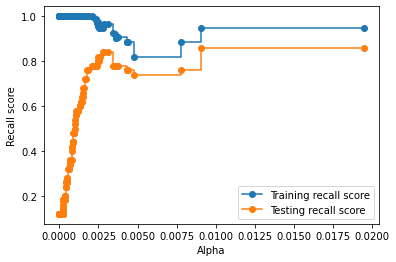

<Figure size 1440x1440 with 0 Axes>

In [9]:
### PLOTTING RECALL SCORES FOR TRAINING AND TESTING AGAINST CCP_ALPHA VALUES
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]
training_recall = []
testing_recall = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state = 99, class_weight = 'balanced', ccp_alpha = ccp_alpha)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    training_recall.append(recall_score(y_train, y_train_pred))
    testing_recall.append(recall_score(y_test, y_test_pred))
ax = plt.subplot()
ax.set_xlabel('Alpha')
ax.set_ylabel('Recall score')
plt.figure(figsize = (20, 20))
ax.plot(ccp_alphas, training_recall, label = 'Training recall score', marker = 'o', drawstyle = 'steps-post')
ax.plot(ccp_alphas, testing_recall, label = 'Testing recall score', marker = 'o', drawstyle = 'steps-post')
ax.legend()
plt.show()

We can see the recall score for the testing data being above 80% in the interval 0.0025 < ccp_alpha < 0.0050 and for ccp_alpha > 0.0075. Now, to find the ideal value, we shall use 5-fold cross validation on the training data with roc_auc as the scoring parameter since we are trying to reduce the FN value. We store the average results from the cross validation on a dataframe and plot it on a graph against the ccp_alpha values.

<Figure size 1152x864 with 0 Axes>

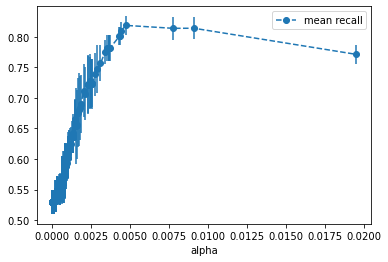

In [10]:
### PLOTTING CROSS VALIDATED RECALL SCORES FOR TRAINING AGAINST CCP_ALPHA VALUES
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state = 99, class_weight = 'balanced', ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'roc_auc')
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
alpha_results = pd.DataFrame(alpha_loop_values, columns = ['alpha', 'mean recall', 'std'])
plt.figure(figsize = (16, 12))
alpha_results.plot(x = 'alpha',
                  y = 'mean recall',
                  yerr = 'std',
                  marker = 'o',
                  linestyle = '--')
plt.show()

We see that the roc_auc score reaches maximum within the range 0.0025 < ccp_alpha < 0.0050. We shall consider the ccp_alpha corresponding to the largest roc_auc score as our ideal ccp_alpha value.

In [11]:
### GETTING THE IDEAL CCP_ALPHA VALUE
ideal_ccp_alpha = float(min(alpha_results[alpha_results['mean recall'] == max(alpha_results['mean recall'])]['alpha']))
ideal_ccp_alpha

0.004752766109359881

With this value, we shall prune the baseline model to get a new tree model.

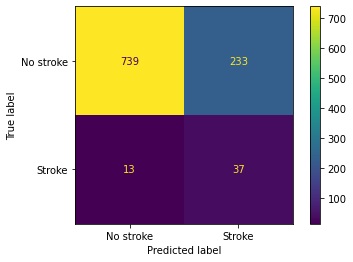

In [12]:
### CREATING A PRUNED TREE MODEL
clf_dt = DecisionTreeClassifier(random_state = 99, class_weight = 'balanced', ccp_alpha = ideal_ccp_alpha)
clf_dt.fit(X_train, y_train)
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Of the 50 stroke cases, 37 were correctly identified by the new model while 13 were mislabelled. This is much better than our baseline model.

In [13]:
### CALCULATING ESSENTIAL METRICS
y_pred_dt = clf_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_dt))
print('Recall score: %f' % recall_score(y_test, y_pred_dt))

              precision    recall  f1-score   support

   No stroke       0.98      0.76      0.86       972
      Stroke       0.14      0.74      0.23        50

    accuracy                           0.76      1022
   macro avg       0.56      0.75      0.54      1022
weighted avg       0.94      0.76      0.83      1022

Accuracy: 0.759295
Recall score: 0.740000


The recall score gone up to 74% while the accuracy has reduced to about 76%, pointing to the already established fact that accuracy is a deceptive metric in this case.

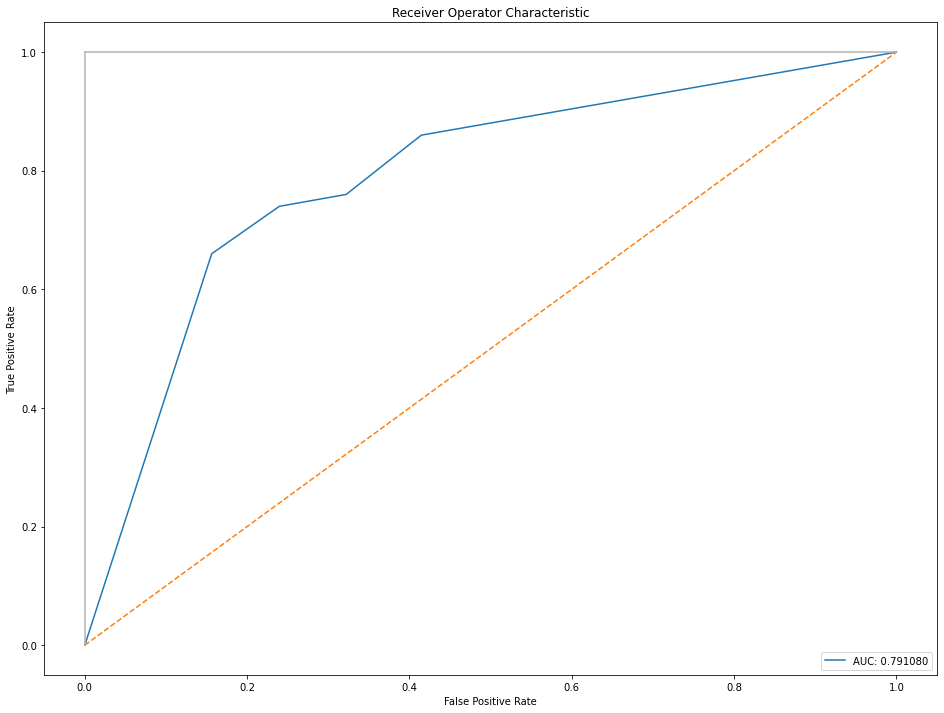

In [14]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_dt = clf_dt.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_dt)
roc_auc = roc_auc_score(y_test, y_prob_dt)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.7911. Thus, we see that our new model is much better than our baseline.


We can also plot the new tree model.

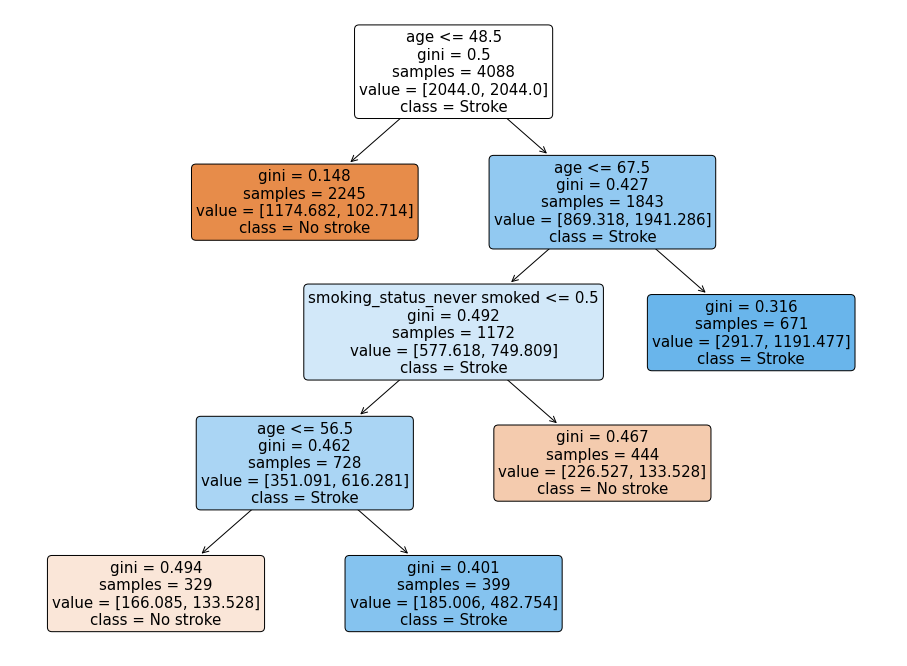

In [15]:
### PLOTTING THE TREE MODEL
plt.figure(figsize = (16, 12))
plot_tree(clf_dt, rounded = True, filled = True, class_names = ['No stroke', 'Stroke'], feature_names = X.columns);

We can see how much the baseline model was pruned to get the new tree. This new tree has only four levels, hence it avoids being overfit to the training data and thus is able to produce good results on new unseen data. Also, if we look at the tree, it says that 'age' and 'smoking_status_never_smoked' are the main deciding features that tells if a person will suffer from stroke, i.e. the tree is interpretable while there is no way we can interpret anything fruitful from the baseline tree.


According to this tree, people aged below 48.5 years have low chances of having a stroke while people over 67.5 years have high chances of having one. For people within the range of ages 48.5 and 67.5 years, their chances of having a stroke depends on their smoking status. If any person within this age range has a high probability of being a non-smoker, he/she has low chances of having a stroke. On the other hand, for those who have a low probability of being a non-smoker, if they are aged below 56.5 then they have low chances of having a stroke, else they are more susceptible to have one.


Next, we will try to further improve the model by tuning it's hyperparameters. For this, we shall use a grid search with 10 fold cross-validation across the possible values for the hyperparameters criterion and max_depth. As we are trying to decrease the FN value, we will use roc_auc as our scoring parameter.


The hyperparameter criterion determines how the impurity in a split is measured while making a tree. The candidates are as follows:
1. gini: it is a measure of the frequency at which any element of the dataset will be mislabelled when it is randomly labeled.
2. entropy: it is a measure of the purity of a split

In [16]:
### TUNING HYPERPARAMETER VALUES USING GRID SEARCH
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 10]
}
clf = DecisionTreeClassifier(random_state = 99, class_weight = 'balanced', ccp_alpha = ideal_ccp_alpha)
grid_fit = GridSearchCV(estimator = clf,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = 10,
                       verbose = 2,
                       n_jobs = -1)
grid_fit.fit(X_train, y_train)
print('Best score: %f' % grid_fit.best_score_)
print('Best criterion: %s' % grid_fit.best_estimator_.get_params()['criterion'])
print('Best max_depth: %f' % grid_fit.best_estimator_.get_params()['max_depth'])

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.808947
Best criterion: gini
Best max_depth: 2.000000


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.7s finished


Now, with these tuned hyperparameter values, we shall create our final Decision Tree model.

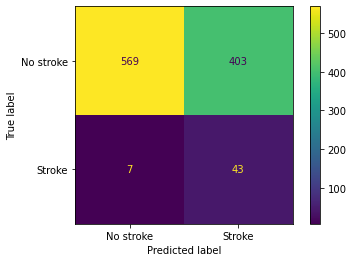

In [17]:
### CREATING THE FINAL MODEL
clf_dt = DecisionTreeClassifier(random_state = 99, class_weight = 'balanced', criterion = 'gini', max_depth = 2, ccp_alpha = ideal_ccp_alpha)
clf_dt.fit(X_train, y_train)
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Of the 50 stroke cases, the final model predicts 43 correctly while it fails to do the same for the other 7. 

In [18]:
### CALCULATING ESSENTIAL METRICS
y_pred_dt = clf_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_dt))
print('Recall score: %f' % recall_score(y_test, y_pred_dt))

              precision    recall  f1-score   support

   No stroke       0.99      0.59      0.74       972
      Stroke       0.10      0.86      0.17        50

    accuracy                           0.60      1022
   macro avg       0.54      0.72      0.45      1022
weighted avg       0.94      0.60      0.71      1022

Accuracy: 0.598826
Recall score: 0.860000


The recall score has gone up to 86% which makes this model the best one so far. Also, keep in mind that the accuracy has gone down to just about 60%. Still, this final model works better in terms of not missing out on possible stroke cases and thus seems ideal for the scenario.

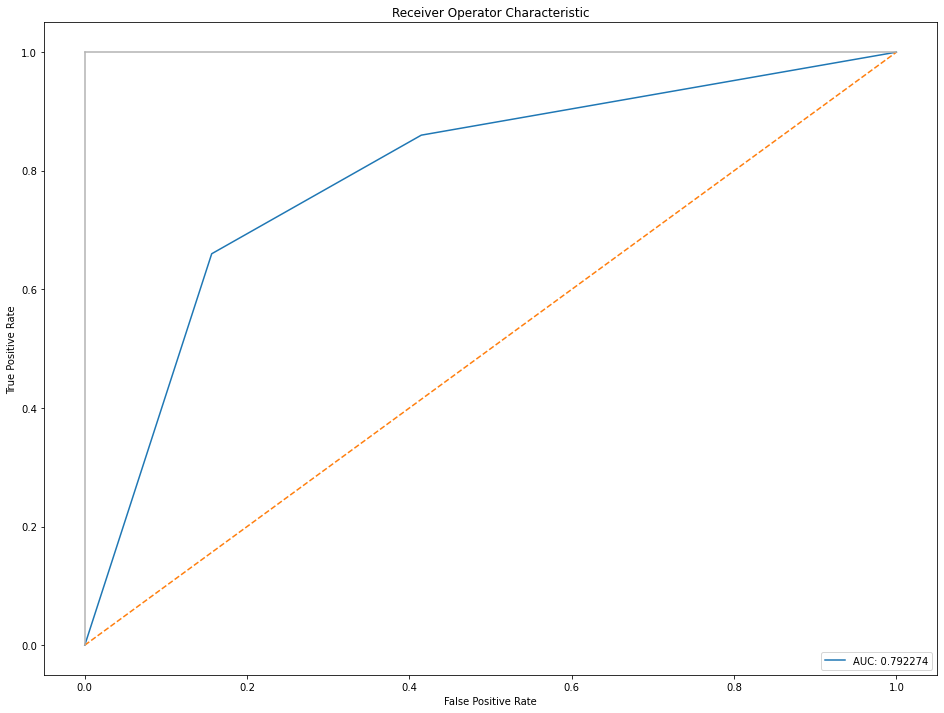

In [19]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_dt = clf_dt.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_dt)
roc_auc = roc_auc_score(y_test, y_prob_dt)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.7923 which is more than it's predecessors. This further proves our case for the final model being the best Decision Tree model out of the three.


We can also plot this final tree model.

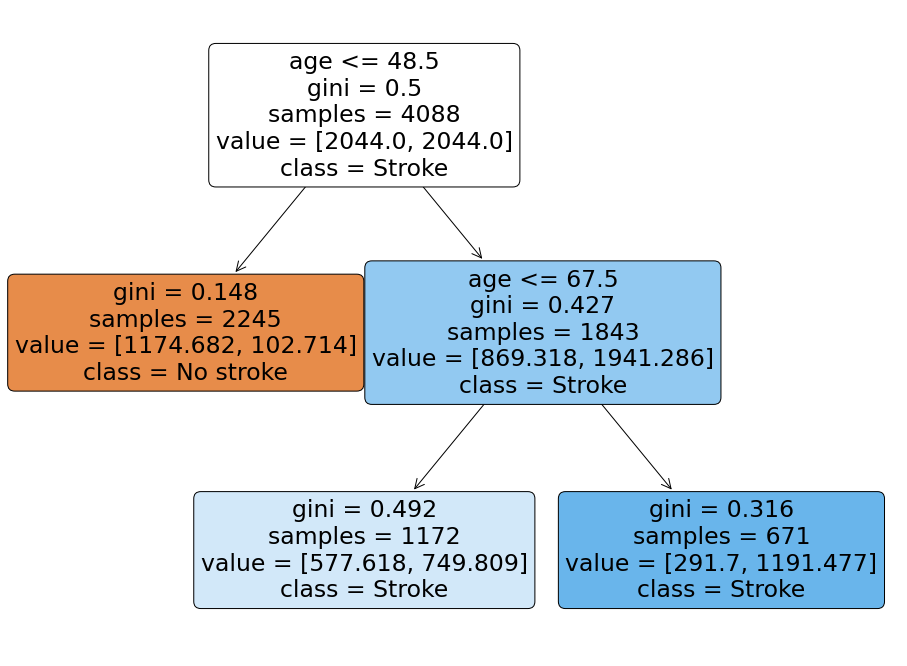

In [20]:
### PLOTTING THE TREE MODEL
plt.figure(figsize = (16, 12))
plot_tree(clf_dt, rounded = True, filled = True, class_names = ['No stroke', 'Stroke'], feature_names = X.columns);

This final tree is small and can easily be understood. It only considers the feature 'age' to decide if a person will suffer from stroke. According to this final tree model, people aged below 48.5 years have low chances of having a stroke while people over 67.5 years have high chances of having one. For people within the range of ages 48.5 and 67.5 years, their chances of having a stroke depends on other factors which were seen in the previous tree. Thus avoiding to go any further than these two levels possibly saved us from overfitting the final tree model to the training data.